# 🌍 AI Travel Planner Agent with LangGraph

## Building an Intelligent Travel Planning System

Welcome to this comprehensive tutorial where we'll build an AI-powered travel planner using LangGraph! This agent will help users plan complete trips by coordinating multiple services and making intelligent decisions.

## 🎯 What We'll Build

Our travel planner will:
- ✈️ **Search for flights** and find the best options
- 🏨 **Find accommodations** based on preferences and budget
- 🌤️ **Check weather conditions** for the destination
- 🎭 **Discover local attractions** and activities
- 📅 **Create detailed itineraries** day by day
- 💰 **Manage budgets** and provide cost breakdowns
- 🔄 **Handle complex workflows** with conditional logic

## 🏗️ Architecture Overview

Our agent will use multiple specialized nodes:
1. **Input Processing** - Parse and validate user requests
2. **Flight Search** - Find and compare flight options
3. **Hotel Search** - Locate suitable accommodations
4. **Weather Check** - Get destination weather information
5. **Attractions Finder** - Discover local points of interest
6. **Itinerary Builder** - Create detailed daily plans
7. **Budget Calculator** - Provide cost analysis
8. **Plan Presenter** - Format and present the final plan

Let's start building! 🚀


In [4]:
from typing import Dict, List, Any, Optional, Annotated, TypedDict
from datetime import datetime, timedelta
import json
import random
from dataclasses import dataclass, asdict

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [6]:
#as we dont have origninal API, lets use a dataclass(as a decorater) to declare the data model

@dataclass
class TravelRequest:
    """User's travel request details"""
    origin: str
    destination: str
    departure_date: str
    return_date: str
    travelers: int
    budget: float
    preferences: List[str]
    trip_type: str  # business, leisure, adventure, family

#Similarly now create one for FlightOptions/ details
@dataclass
class FlightOption:
    """Flight search result"""
    airline: str
    departure_time: str
    arrival_time: str
    duration: str
    price: float
    stops: int

@dataclass
class HotelOption:
    """Hotel search result"""
    name: str
    rating: float
    price_per_night: float
    amenities: List[str]
    location: str
    distance_to_center: float

@dataclass
class WeatherInfo:
    """Weather information"""
    temperature_range: str
    conditions: str
    precipitation_chance: int
    recommendations: List[str]

@dataclass
class Attraction:
    """Tourist attraction information"""
    name: str
    category: str
    rating: float
    estimated_time: str
    cost: float
    description: str
@dataclass
class DayPlan:
    """Daily itinerary"""
    day: int
    date: str
    activities: List[Dict[str, Any]]
    estimated_cost: float
    notes: str

print("📋 Data structures defined:")
print("✅ TravelRequest - User input structure")
print("✅ FlightOption - Flight search results")
print("✅ HotelOption - Hotel search results")
print("✅ WeatherInfo - Weather data")
print("✅ Attraction - Points of interest")
print("✅ DayPlan - Daily itinerary structure")

📋 Data structures defined:
✅ TravelRequest - User input structure
✅ FlightOption - Flight search results
✅ HotelOption - Hotel search results
✅ WeatherInfo - Weather data
✅ Attraction - Points of interest
✅ DayPlan - Daily itinerary structure


In [8]:
# Define the main State for our travel planner graph

class TravelPlannerState(TypedDict):
    """
    Complete state for the travel planner agent.
    
    This state flows through all nodes and accumulates information
    throughout the planning process.
    """
    # User input and preferences
    user_request: str                    # Original user input
    travel_request: Optional[TravelRequest]  # Parsed travel details
    
    # Search results
    flight_options: List[FlightOption]   # Available flights
    hotel_options: List[HotelOption]     # Available hotels
    weather_info: Optional[WeatherInfo]  # Destination weather
    attractions: List[Attraction]        # Local attractions
    
    # Selected options
    selected_flight: Optional[FlightOption]  # Chosen flight
    selected_hotel: Optional[HotelOption]    # Chosen hotel
    
    # Planning results
    itinerary: List[DayPlan]            # Day-by-day plan
    total_cost: float                   # Total trip cost
    cost_breakdown: Dict[str, float]    # Detailed costs
    
    # Process control
    planning_stage: str                 # Current planning phase
    errors: List[str]                   # Any errors encountered
    completed_steps: List[str]          # Completed planning steps
    
    # Final output
    final_plan: str                     # Formatted travel plan

# Initialize our state with default values
def create_initial_state(user_request: str) -> TravelPlannerState:
    """Create initial state from user request"""
    return TravelPlannerState(
        user_request=user_request,
        travel_request=None,
        flight_options=[],
        hotel_options=[],
        weather_info=None,
        attractions=[],
        selected_flight=None,
        selected_hotel=None,
        itinerary=[],
        total_cost=0.0,
        cost_breakdown={},
        planning_stage="input_processing",
        errors=[],
        completed_steps=[],
        final_plan=""
    )

print("🏗️ Travel Planner State defined!")
print("📊 State includes:")
print("   • User requests and preferences")
print("   • Search results for flights, hotels, attractions")
print("   • Selected options and planning results")
print("   • Process control and error handling")
print("   • Final formatted plan")
print("\n💡 This state will flow through all planning nodes")


🏗️ Travel Planner State defined!
📊 State includes:
   • User requests and preferences
   • Search results for flights, hotels, attractions
   • Selected options and planning results
   • Process control and error handling
   • Final formatted plan

💡 This state will flow through all planning nodes


###Now we will create the Nodes

In [ ]:
#Node 1 - Process User Input
def process_user_input(state: TravelPlannerState) -> TravelPlannerState:
    """
    Parse user input and extract travel requirements.
    
    This node:
    1. Analyzes the user's travel request
    2. Extracts key information (dates, destination, budget, etc.)
    3. Validates the input
    4. Creates a structured TravelRequest object
    """
    print("🔍 Processing user input...")
    user_request = state['user_request']  # Get user input from state
    
    # Simple parsing logic (in production, use NLP/LLM for better parsing)
    try:
        # For demo, we'll create a sample parsing/ Dummy data by hardcoding values
        # In reality, you'd use an LLM to extract this information
        
        # Sample extraction logic
        travel_request = TravelRequest(
            origin="New York",  # Would extract from user input
            destination="Paris",  # Would extract from user input
            departure_date="2024-06-15",
            return_date="2024-06-22",
            travelers=2,
            budget=3000.0,
            preferences=["museums", "local cuisine", "history"],
            trip_type="leisure"
        )
        
        print(f"✅ Parsed request:")
        print(f"   🏙️ Origin: {travel_request.origin}")
        print(f"   🎯 Destination: {travel_request.destination}")
        print(f"   📅 Dates: {travel_request.departure_date} to {travel_request.return_date}")
        print(f"   👥 Travelers: {travel_request.travelers}")
        print(f"   💰 Budget: ${travel_request.budget}")
        print(f"   🎭 Type: {travel_request.trip_type}")
        
        return TravelPlannerState(
            **state,
            travel_request=travel_request,
            planning_stage="flight_search",
            completed_steps=state['completed_steps'] + ["input_processing"]
        )
        
    except Exception as e:
        print(f"❌ Error processing input: {e}")
        return TravelPlannerState(
            **state,
            errors=state['errors'] + [f"Input processing error: {e}"],
            planning_stage="error"
        )

In [10]:
# Node 2: Flight Search - Find available flights

def search_flights(state: TravelPlannerState) -> TravelPlannerState:
    """
    Search for available flights based on travel request.
    
    This node:
    1. Uses travel request details to search flights
    2. Filters results based on budget and preferences
    3. Returns top flight options
    """
    print("✈️ Searching for flights...")
    
    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for flight search"]
        )
    
    travel_req = state['travel_request']
    
    # Mock flight search (in production, integrate with flight APIs)
    mock_flights = [
        FlightOption(
            airline="Air France",
            departure_time="08:00",
            arrival_time="21:30",
            duration="7h 30m",
            price=650.0,
            stops=0
        ),
        FlightOption(
            airline="Delta",
            departure_time="14:15",
            arrival_time="04:45+1",
            duration="8h 30m",
            price=580.0,
            stops=1
        ),
        FlightOption(
            airline="British Airways",
            departure_time="22:00",
            arrival_time="11:15+1",
            duration="7h 15m",
            price=720.0,
            stops=0
        )
    ]
    
    # Filter by budget (flight costs for round trip)
    budget_per_person = travel_req.budget / travel_req.travelers / 2  # Rough estimate
    suitable_flights = [f for f in mock_flights if f.price <= budget_per_person]
    
    print(f"✅ Found {len(suitable_flights)} flights within budget:")
    for flight in suitable_flights:
        print(f"   • {flight.airline}: ${flight.price} ({flight.duration}, {flight.stops} stops)")
    
    return TravelPlannerState(
        **state,
        flight_options=suitable_flights,
        planning_stage="hotel_search",
        completed_steps=state['completed_steps'] + ["flight_search"]
    )

print("🛠️ Input processing and flight search nodes defined!")
print("✅ process_user_input - Parses user requests")
print("✅ search_flights - Finds available flights")

🛠️ Input processing and flight search nodes defined!
✅ process_user_input - Parses user requests
✅ search_flights - Finds available flights


In [11]:
# Node 3: Hotel Search - Find suitable hotels
def search_hotels(state: TravelPlannerState) -> TravelPlannerState:
    """
    Search for hotels based on destination and preferences.
    """
    print("🏨 Searching for hotels...")
    
    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for hotel search"]
        )
    
    travel_req = state['travel_request']
    
    # Mock hotel search (in production, integrate with hotel booking APIs)
    mock_hotels = [
        HotelOption(
            name="Hotel du Louvre",
            rating=4.5,
            price_per_night=180.0,
            amenities=["WiFi", "Breakfast", "Gym", "Concierge"],
            location="1st Arrondissement",
            distance_to_center=0.5
        ),
        HotelOption(
            name="Boutique Hotel Marais",
            rating=4.2,
            price_per_night=120.0,
            amenities=["WiFi", "Breakfast", "Bar"],
            location="4th Arrondissement",
            distance_to_center=1.2
        ),
        HotelOption(
            name="Budget Inn Montmartre",
            rating=3.8,
            price_per_night=85.0,
            amenities=["WiFi", "24h Reception"],
            location="18th Arrondissement",
            distance_to_center=3.5
        )
    ]

    # Calculate trip duration for budget calculation
    from datetime import datetime
    departure = datetime.strptime(travel_req.departure_date, "%Y-%m-%d")
    return_date = datetime.strptime(travel_req.return_date, "%Y-%m-%d")
    nights = (return_date - departure).days

    # Filter hotels by budget
    remaining_budget = travel_req.budget - (len(state['flight_options']) * state['flight_options'][0].price * 2 if state['flight_options'] else 0)
    budget_per_night = (remaining_budget * 0.6) / nights  # Allocate 60% of remaining budget to hotels

    suitable_hotels = [h for h in mock_hotels if h.price_per_night <= budget_per_night]

    print(f"✅ Found {len(suitable_hotels)} hotels within budget (${budget_per_night:.0f}/night):")
    for hotel in suitable_hotels:
        total_cost = hotel.price_per_night * nights
        print(f"   • {hotel.name}: ${hotel.price_per_night}/night (${total_cost:.0f} total, ⭐{hotel.rating})")

    return TravelPlannerState(
        **state,
        hotel_options=suitable_hotels,
        planning_stage="weather_check",
        completed_steps=state['completed_steps'] + ["hotel_search"]
    )

In [12]:
# Node 4: Weather Check - Get destination weather info
def check_weather(state: TravelPlannerState) -> TravelPlannerState:
    """
    Check weather conditions for the destination and dates.
    """
    print("🌤️ Checking weather conditions...")
    
    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for weather check"]
        )
    
    # Mock weather data (in production, integrate with weather APIs)
    weather_conditions = [
        ("Sunny", "20-25°C", 10, ["Light clothing", "Sunglasses", "Sunscreen"]),
        ("Partly Cloudy", "18-23°C", 20, ["Layers", "Light jacket", "Comfortable shoes"]),
        ("Rainy", "15-20°C", 70, ["Umbrella", "Waterproof jacket", "Boots"])
    ]
    
    # Randomly select weather for demo
    condition, temp_range, precip, recommendations = random.choice(weather_conditions)
    
    weather_info = WeatherInfo(
        temperature_range=temp_range,
        conditions=condition,
        precipitation_chance=precip,
        recommendations=recommendations
    )
    
    print(f"✅ Weather forecast:")
    print(f"   🌡️ Temperature: {weather_info.temperature_range}")
    print(f"   ☁️ Conditions: {weather_info.conditions}")
    print(f"   🌧️ Rain chance: {weather_info.precipitation_chance}%")
    print(f"   🎒 Pack: {', '.join(weather_info.recommendations)}")
    
    return TravelPlannerState(
        **state,
        weather_info=weather_info,
        planning_stage="attractions_search",
        completed_steps=state['completed_steps'] + ["weather_check"]
    )

print("🛠️ Hotel search and weather check nodes defined!")
print("✅ search_hotels - Finds suitable accommodations")
print("✅ check_weather - Gets destination weather info")

🛠️ Hotel search and weather check nodes defined!
✅ search_hotels - Finds suitable accommodations
✅ check_weather - Gets destination weather info


In [13]:
# Node 5: Find Attractions - Discover local points of interest

def find_attractions(state: TravelPlannerState) -> TravelPlannerState:
    """
    Find attractions and activities based on user preferences.
    """
    print("🎭 Finding attractions and activities...")
    
    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for attractions search"]
        )
    
    travel_req = state['travel_request']
    
    # Mock attractions database (in production, integrate with tourism APIs)
    all_attractions = [
        Attraction("Louvre Museum", "museum", 4.6, "3-4 hours", 17.0, "World's largest art museum"),
        Attraction("Eiffel Tower", "landmark", 4.5, "2-3 hours", 25.0, "Iconic iron tower with city views"),
        Attraction("Notre-Dame Cathedral", "historic", 4.4, "1-2 hours", 0.0, "Gothic masterpiece cathedral"),
        Attraction("Montmartre District", "neighborhood", 4.3, "4-5 hours", 0.0, "Artistic hill with Sacré-Cœur"),
        Attraction("Seine River Cruise", "activity", 4.2, "1-2 hours", 15.0, "Scenic boat tour of Paris"),
        Attraction("Local Cooking Class", "experience", 4.7, "3-4 hours", 85.0, "Learn French cuisine"),
        Attraction("Versailles Palace", "historic", 4.8, "6-8 hours", 20.0, "Opulent royal palace and gardens"),
        Attraction("Latin Quarter Food Tour", "food", 4.5, "3 hours", 65.0, "Taste local specialties")
    ]
    
    # Filter attractions based on preferences
    preferred_attractions = []
    for attraction in all_attractions:
        # Match user preferences
        if any(pref in attraction.category or pref in attraction.description.lower() 
               for pref in travel_req.preferences):
            preferred_attractions.append(attraction)
        # Also include highly rated landmarks
        elif attraction.category in ["landmark", "historic"] and attraction.rating >= 4.4:
            preferred_attractions.append(attraction)
    
    # Sort by rating and limit to top options
    preferred_attractions.sort(key=lambda x: x.rating, reverse=True)
    top_attractions = preferred_attractions[:8]  # Limit to 8 attractions
    
    print(f"✅ Found {len(top_attractions)} attractions matching preferences:")
    for attraction in top_attractions:
        print(f"   • {attraction.name} (⭐{attraction.rating}): ${attraction.cost} - {attraction.estimated_time}")
    
    return TravelPlannerState(
        **state,
        attractions=top_attractions,
        planning_stage="select_options",
        completed_steps=state['completed_steps'] + ["attractions_search"]
    )

# Node 6: Select Best Options - Choose flights and hotels

def select_best_options(state: TravelPlannerState) -> TravelPlannerState:
    """
    Select the best flight and hotel options based on criteria.
    """
    print("🎯 Selecting best options...")
    
    # Select best flight (balance price and convenience)
    best_flight = None
    if state['flight_options']:
        # Score flights (lower price + fewer stops = better score)
        scored_flights = []
        for flight in state['flight_options']:
            # Simple scoring: price weight + stops penalty
            score = flight.price + (flight.stops * 50)  # $50 penalty per stop
            scored_flights.append((score, flight))
        
        # Select flight with best score
        best_flight = min(scored_flights, key=lambda x: x[0])[1]
        print(f"✅ Selected flight: {best_flight.airline} (${best_flight.price}, {best_flight.stops} stops)")
    
    # Select best hotel (balance price, rating, and location)
    best_hotel = None
    if state['hotel_options']:
        # Score hotels (consider price, rating, and location)
        scored_hotels = []
        for hotel in state['hotel_options']:
            # Score: lower price is better, higher rating is better, closer to center is better
            price_score = hotel.price_per_night  # Lower is better
            rating_score = (5.0 - hotel.rating) * 20  # Convert rating to penalty (lower is better)
            location_score = hotel.distance_to_center * 10  # Distance penalty
            
            total_score = price_score + rating_score + location_score
            scored_hotels.append((total_score, hotel))
        
        # Select hotel with best score
        best_hotel = min(scored_hotels, key=lambda x: x[0])[1]
        print(f"✅ Selected hotel: {best_hotel.name} (${best_hotel.price_per_night}/night, ⭐{best_hotel.rating})")
    
    return TravelPlannerState(
        **state,
        selected_flight=best_flight,
        selected_hotel=best_hotel,
        planning_stage="create_itinerary",
        completed_steps=state['completed_steps'] + ["select_options"]
    )

print("🛠️ Attractions finder and selection nodes defined!")
print("✅ find_attractions - Discovers local points of interest")
print("✅ select_best_options - Chooses optimal flights and hotels")


🛠️ Attractions finder and selection nodes defined!
✅ find_attractions - Discovers local points of interest
✅ select_best_options - Chooses optimal flights and hotels


In [14]:
# Node 7: Create Itinerary - Build detailed day-by-day plans

def create_itinerary(state: TravelPlannerState) -> TravelPlannerState:
    """
    Create a detailed day-by-day itinerary based on selected options and attractions.
    """
    print("📅 Creating detailed itinerary...")
    
    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for itinerary creation"]
        )
    
    travel_req = state['travel_request']
    
    # Calculate trip duration
    from datetime import datetime, timedelta
    departure = datetime.strptime(travel_req.departure_date, "%Y-%m-%d")
    return_date = datetime.strptime(travel_req.return_date, "%Y-%m-%d")
    days = (return_date - departure).days
    
    # Distribute attractions across days
    attractions = state['attractions']
    itinerary = []
    
    # Simple distribution logic (in production, use more sophisticated algorithms)
    attractions_per_day = max(1, len(attractions) // max(1, days))
    
    for day in range(days):
        current_date = departure + timedelta(days=day)
        day_attractions = attractions[day * attractions_per_day:(day + 1) * attractions_per_day]
        
        # Create activities for the day
        activities = []
        daily_cost = 0.0
        
        if day == 0:  # Arrival day
            activities.append({
                "time": "Morning",
                "activity": "Arrival and hotel check-in",
                "description": f"Arrive via {state['selected_flight'].airline if state['selected_flight'] else 'flight'}, check into {state['selected_hotel'].name if state['selected_hotel'] else 'hotel'}",
                "cost": 0.0
            })
        
        # Add attraction activities
        for i, attraction in enumerate(day_attractions):
            time_slots = ["Morning", "Afternoon", "Evening"]
            time_slot = time_slots[min(i, 2)]
            
            activities.append({
                "time": time_slot,
                "activity": attraction.name,
                "description": f"{attraction.description} ({attraction.estimated_time})",
                "cost": attraction.cost
            })
            daily_cost += attraction.cost
        
        # Add meals
        if not any("food" in act["activity"].lower() for act in activities):
            activities.append({
                "time": "Evening",
                "activity": "Local Dining",
                "description": "Experience local cuisine at a recommended restaurant",
                "cost": 45.0
            })
            daily_cost += 45.0
        
        if day == days - 1:  # Departure day
            activities.append({
                "time": "Late Morning",
                "activity": "Check-out and departure",
                "description": "Hotel check-out and travel to airport",
                "cost": 0.0
            })
        
        # Create day plan
        day_plan = DayPlan(
            day=day + 1,
            date=current_date.strftime("%Y-%m-%d"),
            activities=activities,
            estimated_cost=daily_cost,
            notes=f"Weather: {state['weather_info'].conditions if state['weather_info'] else 'Check forecast'}"
        )
        
        itinerary.append(day_plan)
    
    print(f"✅ Created {len(itinerary)}-day itinerary:")
    for day_plan in itinerary:
        print(f"   📅 Day {day_plan.day} ({day_plan.date}): {len(day_plan.activities)} activities, ${day_plan.estimated_cost:.0f}")
    
    return TravelPlannerState(
        **state,
        itinerary=itinerary,
        planning_stage="calculate_budget",
        completed_steps=state['completed_steps'] + ["create_itinerary"]
    )

# Node 8: Calculate Budget - Provide detailed cost breakdown

def calculate_budget(state: TravelPlannerState) -> TravelPlannerState:
    """
    Calculate total trip cost and provide detailed breakdown.
    """
    print("💰 Calculating budget and costs...")
    
    cost_breakdown = {}
    total_cost = 0.0
    
    # Flight costs
    if state['selected_flight']:
        flight_cost = state['selected_flight'].price * state['travel_request'].travelers * 2  # Round trip
        cost_breakdown['Flights'] = flight_cost
        total_cost += flight_cost
    
    # Hotel costs
    if state['selected_hotel'] and state['travel_request']:
        from datetime import datetime
        departure = datetime.strptime(state['travel_request'].departure_date, "%Y-%m-%d")
        return_date = datetime.strptime(state['travel_request'].return_date, "%Y-%m-%d")
        nights = (return_date - departure).days
        
        hotel_cost = state['selected_hotel'].price_per_night * nights
        cost_breakdown['Accommodation'] = hotel_cost
        total_cost += hotel_cost
    
    # Activities and attractions costs
    activities_cost = sum(day.estimated_cost for day in state['itinerary'])
    if activities_cost > 0:
        cost_breakdown['Activities & Dining'] = activities_cost
        total_cost += activities_cost
    
    # Add miscellaneous costs (transportation, tips, shopping)
    misc_cost = total_cost * 0.15  # 15% for miscellaneous
    cost_breakdown['Transportation & Misc'] = misc_cost
    total_cost += misc_cost
    
    # Budget analysis
    if state['travel_request']:
        budget = state['travel_request'].budget
        budget_status = "✅ Within budget" if total_cost <= budget else "⚠️ Over budget"
        remaining = budget - total_cost
        
        print(f"✅ Budget Analysis:")
        print(f"   💰 Total Cost: ${total_cost:.2f}")
        print(f"   🎯 Budget: ${budget:.2f}")
        print(f"   📊 Status: {budget_status}")
        print(f"   💵 Remaining: ${remaining:.2f}")
        
        print(f"\n📋 Cost Breakdown:")
        for category, cost in cost_breakdown.items():
            percentage = (cost / total_cost) * 100
            print(f"   • {category}: ${cost:.2f} ({percentage:.1f}%)")
    
    return TravelPlannerState(
        **state,
        total_cost=total_cost,
        cost_breakdown=cost_breakdown,
        planning_stage="format_plan",
        completed_steps=state['completed_steps'] + ["calculate_budget"]
    )

print("🛠️ Itinerary and budget calculation nodes defined!")
print("✅ create_itinerary - Builds detailed day-by-day plans")
print("✅ calculate_budget - Provides comprehensive cost analysis")

🛠️ Itinerary and budget calculation nodes defined!
✅ create_itinerary - Builds detailed day-by-day plans
✅ calculate_budget - Provides comprehensive cost analysis


In [15]:
# Node 9: Format Final Plan - Create beautiful, comprehensive travel plan

def format_final_plan(state: TravelPlannerState) -> TravelPlannerState:
    """
    Format all planning information into a comprehensive, readable travel plan.
    """
    print("📝 Formatting final travel plan...")
    
    # Build comprehensive travel plan
    plan_sections = []
    
    # Header
    if state['travel_request']:
        tr = state['travel_request']
        plan_sections.append(f"""
🌍 YOUR PERSONALIZED TRAVEL PLAN 🌍
═══════════════════════════════════════

✈️ Trip Overview:
   📍 Destination: {tr.destination}
   🏠 Origin: {tr.origin}
   📅 Travel Dates: {tr.departure_date} to {tr.return_date}
   👥 Travelers: {tr.travelers}
   💰 Budget: ${tr.budget:.2f}
   🎭 Trip Type: {tr.trip_type.title()}
""")
    
    # Selected Transportation
    if state['selected_flight']:
        flight = state['selected_flight']
        plan_sections.append(f"""
✈️ SELECTED FLIGHT:
   🛫 Airline: {flight.airline}
   🕐 Departure: {flight.departure_time}
   🕘 Arrival: {flight.arrival_time}
   ⏱️ Duration: {flight.duration}
   🛑 Stops: {flight.stops}
   💵 Price: ${flight.price} per person
""")
    
    # Selected Accommodation
    if state['selected_hotel']:
        hotel = state['selected_hotel']
        plan_sections.append(f"""
🏨 SELECTED ACCOMMODATION:
   🏩 Hotel: {hotel.name}
   ⭐ Rating: {hotel.rating}/5.0
   📍 Location: {hotel.location}
   🚶 Distance to Center: {hotel.distance_to_center} km
   💵 Price: ${hotel.price_per_night} per night
   🎯 Amenities: {', '.join(hotel.amenities)}
""")
    
    # Weather Information
    if state['weather_info']:
        weather = state['weather_info']
        plan_sections.append(f"""
🌤️ WEATHER FORECAST:
   🌡️ Temperature: {weather.temperature_range}
   ☁️ Conditions: {weather.conditions}
   🌧️ Rain Chance: {weather.precipitation_chance}%
   🎒 Packing Tips: {', '.join(weather.recommendations)}
""")
    
    # Daily Itinerary
    if state['itinerary']:
        plan_sections.append("\n📅 DETAILED ITINERARY:")
        for day_plan in state['itinerary']:
            plan_sections.append(f"""
   ═══ DAY {day_plan.day} - {day_plan.date} ═══
   💰 Daily Budget: ${day_plan.estimated_cost:.2f}
   📝 Notes: {day_plan.notes}
   
   Activities:""")
            
            for activity in day_plan.activities:
                cost_str = f" (${activity['cost']:.2f})" if activity['cost'] > 0 else ""
                plan_sections.append(f"""   • {activity['time']}: {activity['activity']}{cost_str}
     📖 {activity['description']}""")
    
    # Budget Summary
    if state['cost_breakdown']:
        plan_sections.append(f"""
💰 BUDGET BREAKDOWN:
   🎯 Total Trip Cost: ${state['total_cost']:.2f}
   💳 Budget Status: {"✅ Within Budget" if state['total_cost'] <= state['travel_request'].budget else "⚠️ Over Budget"}
   
   📊 Cost Details:""")
        
        for category, cost in state['cost_breakdown'].items():
            percentage = (cost / state['total_cost']) * 100
            plan_sections.append(f"   • {category}: ${cost:.2f} ({percentage:.1f}%)")
    
    # Tips and Recommendations
    plan_sections.append(f"""
💡 TRAVEL TIPS:
   📱 Download offline maps and translation apps
   💳 Notify your bank of travel dates
   🎫 Book attraction tickets in advance when possible
   📋 Keep copies of important documents
   🌐 Check visa requirements and vaccination needs
   
🎉 Have an amazing trip! Safe travels! 🎉
═══════════════════════════════════════
""")
    
    final_plan = "\n".join(plan_sections)
    
    print("✅ Final travel plan formatted successfully!")
    print(f"📄 Plan length: {len(final_plan)} characters")
    
    return TravelPlannerState(
        **state,
        final_plan=final_plan,
        planning_stage="completed",
        completed_steps=state['completed_steps'] + ["format_plan"]
    )

# Conditional routing functions

def route_planning_stage(state: TravelPlannerState) -> str:
    """
    Route based on current planning stage.
    This enables our workflow to follow the correct sequence.
    """
    stage = state['planning_stage']
    print(f"🔄 Routing from stage: {stage}")
    
    # Error handling
    if state['errors']:
        return "error"
    
    # Normal flow routing
    routing_map = {
        "input_processing": "flight_search",
        "flight_search": "hotel_search", 
        "hotel_search": "weather_check",
        "weather_check": "attractions_search",
        "attractions_search": "select_options",
        "select_options": "create_itinerary",
        "create_itinerary": "calculate_budget",
        "calculate_budget": "format_plan",
        "format_plan": "end",
        "completed": "end"
    }
    
    next_stage = routing_map.get(stage, "end")
    print(f"➡️ Next stage: {next_stage}")
    return next_stage

def handle_error(state: TravelPlannerState) -> TravelPlannerState:
    """
    Handle any errors that occurred during planning.
    """
    print("❌ Handling planning errors...")
    
    error_summary = "\n".join(state['errors'])
    final_plan = f"""
🚨 TRAVEL PLANNING ERROR 🚨
═══════════════════════════

Unfortunately, we encountered some issues while planning your trip:

{error_summary}

Please try again with different parameters or contact support for assistance.

Completed steps: {', '.join(state['completed_steps'])}
"""
    
    return TravelPlannerState(
        **state,
        final_plan=final_plan,
        planning_stage="error_handled"
    )

print("🛠️ Final formatting and routing functions defined!")
print("✅ format_final_plan - Creates comprehensive travel plan")
print("✅ route_planning_stage - Handles workflow routing")
print("✅ handle_error - Manages error scenarios")


🛠️ Final formatting and routing functions defined!
✅ format_final_plan - Creates comprehensive travel plan
✅ route_planning_stage - Handles workflow routing
✅ handle_error - Manages error scenarios


In [16]:
# Build the Travel Planner Graph

print("🏗️ Building the Travel Planner LangGraph...")

# Create the StateGraph
travel_planner_graph = StateGraph(TravelPlannerState)

# Add all nodes to the graph
travel_planner_graph.add_node("process_input", process_user_input)
travel_planner_graph.add_node("search_flights", search_flights)
travel_planner_graph.add_node("search_hotels", search_hotels)
travel_planner_graph.add_node("check_weather", check_weather)
travel_planner_graph.add_node("find_attractions", find_attractions)
travel_planner_graph.add_node("select_options", select_best_options)
travel_planner_graph.add_node("create_itinerary", create_itinerary)
travel_planner_graph.add_node("calculate_budget", calculate_budget)
travel_planner_graph.add_node("format_plan", format_final_plan)
travel_planner_graph.add_node("handle_error", handle_error)

# Add entry point
travel_planner_graph.add_edge(START, "process_input")

# Add conditional routing based on planning stage
#Basically if there is process input and there is no error, then search flights, else handle error.
travel_planner_graph.add_conditional_edges(
    "process_input",
    route_planning_stage,
    {
        "flight_search": "search_flights",
        "error": "handle_error"
    }
)


travel_planner_graph.add_conditional_edges(
    "search_flights",
    route_planning_stage,
    {
        "hotel_search": "search_hotels",
        "error": "handle_error"
    }
)


travel_planner_graph.add_conditional_edges(
    "search_hotels",
    route_planning_stage,
    {
        "weather_check": "check_weather",
        "error": "handle_error"
    }
)

travel_planner_graph.add_conditional_edges(
    "check_weather",
    route_planning_stage,
    {
        "attractions_search": "find_attractions",
        "error": "handle_error"
    }
)


travel_planner_graph.add_conditional_edges(
    "find_attractions",
    route_planning_stage,
    {
        "select_options": "select_options",
        "error": "handle_error"
    }
)


travel_planner_graph.add_conditional_edges(
    "select_options",
    route_planning_stage,
    {
        "create_itinerary": "create_itinerary",
        "error": "handle_error"
    }
)


travel_planner_graph.add_conditional_edges(
    "create_itinerary",
    route_planning_stage,
    {
        "calculate_budget": "calculate_budget",
        "error": "handle_error"
    }
)

travel_planner_graph.add_conditional_edges(
    "calculate_budget",
    route_planning_stage,
    {
        "format_plan": "format_plan",
        "error": "handle_error"
    }
)


travel_planner_graph.add_conditional_edges(
    "format_plan",
    route_planning_stage,
    {
        "end": END,
        "error": "handle_error"
    }
)

travel_planner_graph.add_edge("handle_error", END)

print("✅ Graph structure complete!")
print("📊 Nodes added:")
print("   • process_input - Parse user request")
print("   • search_flights - Find flight options")
print("   • search_hotels - Find accommodation")
print("   • check_weather - Get weather info")
print("   • find_attractions - Discover activities")
print("   • select_options - Choose best options")
print("   • create_itinerary - Build daily plans")
print("   • calculate_budget - Cost analysis")
print("   • format_plan - Create final plan")
print("   • handle_error - Error management")
print("\n🔗 Conditional routing configured for adaptive workflow")

🏗️ Building the Travel Planner LangGraph...
✅ Graph structure complete!
📊 Nodes added:
   • process_input - Parse user request
   • search_flights - Find flight options
   • search_hotels - Find accommodation
   • check_weather - Get weather info
   • find_attractions - Discover activities
   • select_options - Choose best options
   • create_itinerary - Build daily plans
   • calculate_budget - Cost analysis
   • format_plan - Create final plan
   • handle_error - Error management

🔗 Conditional routing configured for adaptive workflow


In [17]:
# Compile and Test the Travel Planner

# Compile the graph
travel_planner = travel_planner_graph.compile()

print("⚙️ Compiling travel planner graph...")
print("✅ Travel Planner Agent compiled successfully!")
print("🚀 Ready to plan amazing trips!")

⚙️ Compiling travel planner graph...
✅ Travel Planner Agent compiled successfully!
🚀 Ready to plan amazing trips!


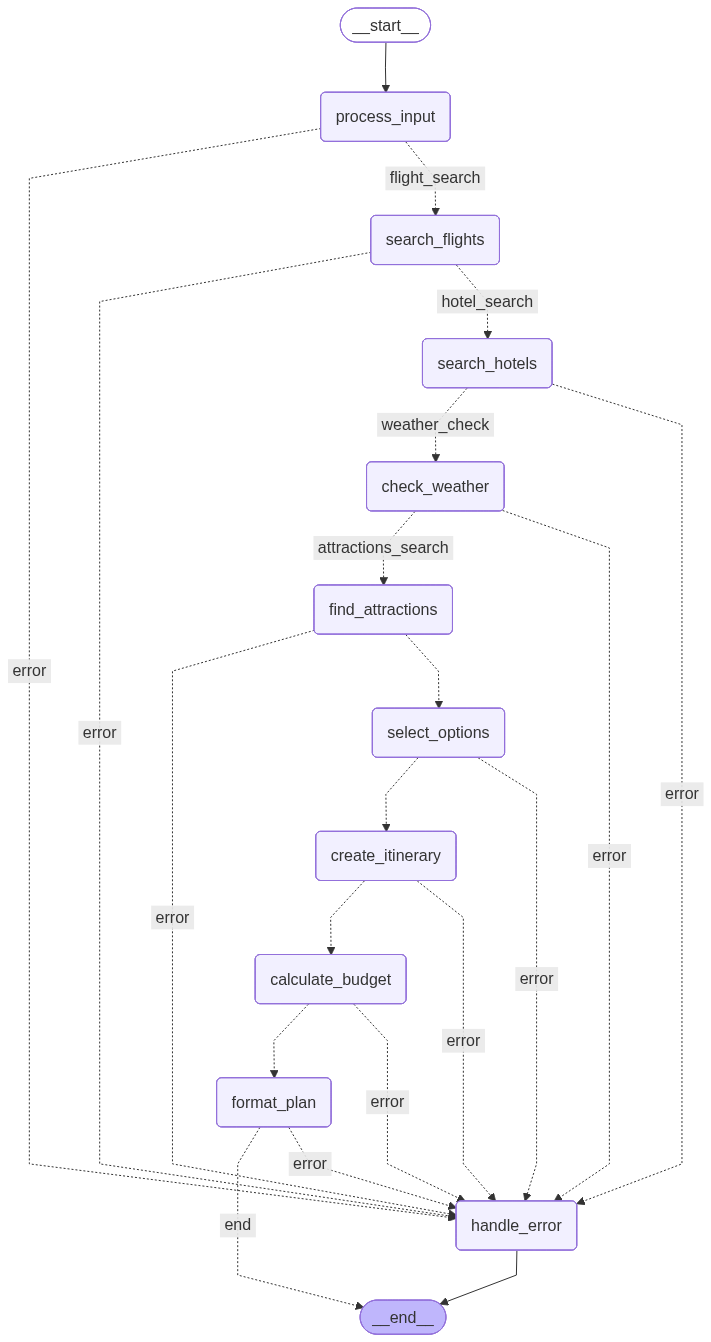

In [18]:
from IPython.display import Image, display

try:
    display(Image(travel_planner.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [19]:
# Compile and Test the Travel Planner

# Compile the graph
travel_planner = travel_planner_graph.compile()

print("⚙️ Compiling travel planner graph...")
print("✅ Travel Planner Agent compiled successfully!")
print("🚀 Ready to plan amazing trips!")

# Test function
def plan_trip(user_request: str):
    """
    Plan a complete trip based on user request.
    
    Args:
        user_request: User's travel planning request
        
    Returns:
        Complete travel plan
    """
    print(f"🌍 Planning trip based on: '{user_request}'")
    print("=" * 60)
    
    # Create initial state
    initial_state = create_initial_state(user_request)
    
    # Execute the travel planning workflow
    try:
        final_state = travel_planner.invoke(initial_state)
        
        print("\n" + "=" * 60)
        print("🎉 TRAVEL PLANNING COMPLETE!")
        print("=" * 60)
        
        # Print the beautiful final plan
        if final_state.get('final_plan'):
            print(final_state['final_plan'])
        else:
            print("❌ No final plan generated")
            
        return final_state
        
    except Exception as e:
        print(f"❌ Error during planning: {e}")
        return None

# Graph visualization
print("\n📊 Graph Visualization:")
print("=" * 40)
try:
    # Simple ASCII representation
    print("""
┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│   START     │───▶│ process_input│───▶│search_flights│───▶│search_hotels │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
                                                                    │
                                                                    ▼
┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│handle_error │◀───┤    END       │◀───┤format_plan   │◀───┤check_weather │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
       ▲                   ▲                   ▲                   │
       │                   │                   │                   ▼
       │           ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
       └───────────┤calc_budget   │◀───┤create_itinerary◀─┤find_attractions
                   └──────────────┘    └──────────────┘    └──────────────┘
                           ▲                   ▲                   │
                           │                   │                   ▼
                   ┌──────────────┐           │            ┌──────────────┐
                   │select_options│───────────┘            │  (routing)   │
                   └──────────────┘                        └──────────────┘
    """)
    
    print("🔗 Workflow Features:")
    print("   • Conditional routing based on planning stage")
    print("   • Error handling at every step")
    print("   • State accumulation throughout process")
    print("   • Comprehensive output formatting")
    
except Exception as e:
    print(f"Visualization error: {e}")

print("\n🎯 Travel Planner Agent is ready to use!")
print("💡 Call plan_trip(your_request) to start planning")

⚙️ Compiling travel planner graph...
✅ Travel Planner Agent compiled successfully!
🚀 Ready to plan amazing trips!

📊 Graph Visualization:

┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│   START     │───▶│ process_input│───▶│search_flights│───▶│search_hotels │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
                                                                    │
                                                                    ▼
┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│handle_error │◀───┤    END       │◀───┤format_plan   │◀───┤check_weather │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
       ▲                   ▲                   ▲                   │
       │                   │                   │                   ▼
       │           ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
       └───────────┤calc_budget   │◀───┤create_itin

In [20]:
print("🎬 DEMO: Planning a sample trip")
print("=" * 50)

# Sample user request
sample_request = """
I want to plan a romantic trip to Paris for 3 people from June 15-22, 2024. 
Our budget is $3000. We love museums, local cuisine, and historic sites. 
We're departing from New York.
"""

print(f"📝 Sample Request:")
print(sample_request)

🎬 DEMO: Planning a sample trip
📝 Sample Request:

I want to plan a romantic trip to Paris for 3 people from June 15-22, 2024. 
Our budget is $3000. We love museums, local cuisine, and historic sites. 
We're departing from New York.



In [21]:
result = plan_trip(sample_request)

🌍 Planning trip based on: '
I want to plan a romantic trip to Paris for 3 people from June 15-22, 2024. 
Our budget is $3000. We love museums, local cuisine, and historic sites. 
We're departing from New York.
'
🔍 Processing user input...
✅ Parsed request:
   🏙️ Origin: New York
   🎯 Destination: Paris
   📅 Dates: 2024-06-15 to 2024-06-22
   👥 Travelers: 2
   💰 Budget: $3000.0
   🎭 Type: leisure
❌ Error processing input: __main__.TravelPlannerState() got multiple values for keyword argument 'travel_request'
❌ Error during planning: __main__.TravelPlannerState() got multiple values for keyword argument 'errors'
